# Laboratory Work №1
### Researching algorithms on trees and decision tree structure
#### Created by Iia Maharyta and Oksana Moskviak

In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [2]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

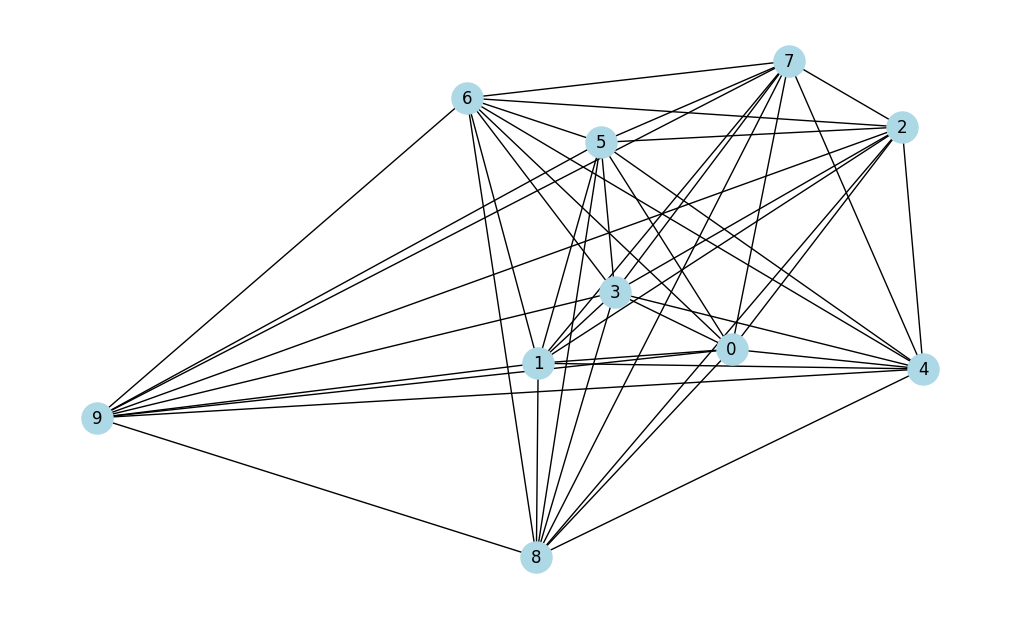

In [4]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1

### Kruskal's algorithm

Implementation of Kruskal's greedy algorithm to find <b> the minimum spanning tree </b> <br>
for a weighted, connected, undirected graph.

In [5]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

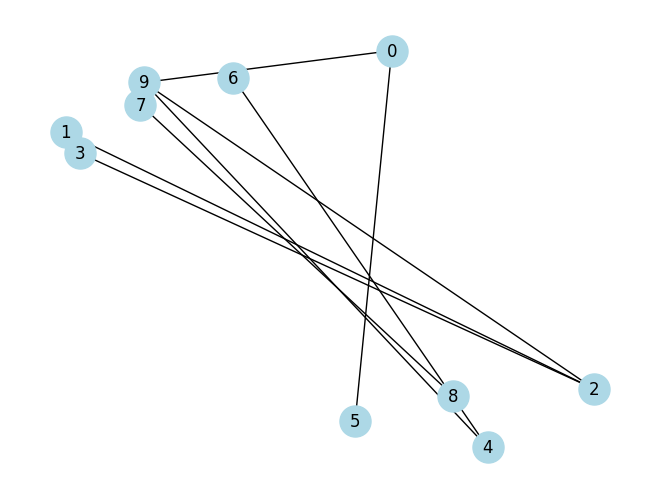

In [6]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [7]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 5), (0, 9), (1, 2), (2, 3), (2, 9), (4, 6), (4, 9), (7, 9), (7, 8)]),
 9)

In [8]:
def kruskal_algorithm(graph) -> list:
    """
    The realization of Kruskal's algorithm
    used for finding the minimum spanning tree
    of a graph.

    :param graph: Randomly generated graph
    :return: list, List of edges needed to create MST
    """
    edges = list(graph.edges(data = True))
    sorted_edges = sorted(edges, key = lambda x: x[2]['weight'])
    mstk_v = {}
    mstk = {}


    def unite_groups(key_1: int, key_2: int):
        """
        Function unites groups into one.

        :param key_1, key_2: int, the key of a group to unite
        """
        mstk_v[key_1] = mstk_v[key_1].union(mstk_v[key_2])
        mstk_v.pop(key_2)
        mstk[key_1] = mstk[key_1] + mstk[key_2]
        mstk[key_1].append((edge[0], edge[1]))
        mstk.pop(key_2)

    i = 0
    for edge in sorted_edges:
        key_0 = 0
        key_1 = 0
        for s in mstk_v.items():
            if edge[0] in s[1]:
                key_0 = s[0]
                break 
        for s in mstk_v.items():
            if edge[1] in s[1]:
                key_1 = s[0]
                break 
        if not key_0 and not key_1 :
            i += 1
            mstk_v.setdefault(i, set())
            mstk_v[i].add(edge[0])
            mstk_v[i].add(edge[1])
            mstk.setdefault(i, [])
            mstk[i].append((edge[0], edge[1]))
        else:
            if key_0 == key_1:
                continue
            elif not key_0 or not key_1:
                group_key = key_0 if key_0 else key_1
                mstk_v[group_key].add(edge[0])
                mstk_v[group_key].add(edge[1])
                mstk[group_key].append((edge[0], edge[1]))
            else:
                if len(mstk_v[key_0]) >= len(mstk_v[key_1]):
                    unite_groups(key_0, key_1)
                else:
                    unite_groups(key_1, key_0)

    return sorted(mstk.values())


### Implementation details
At the beggining function receives randomly generated graph.

Then we extract edges, sort them by weight which is needed for algorithm's instance and initialize <br>
2 dictionaries <b>mstk_v</b> and <b>mstk</b> - dictionaries that contain information
about vertices and edges <br> in minimum spanning tree and update it as algorithm is being performed.

### Starting the algorithm

## Subtask 1.2

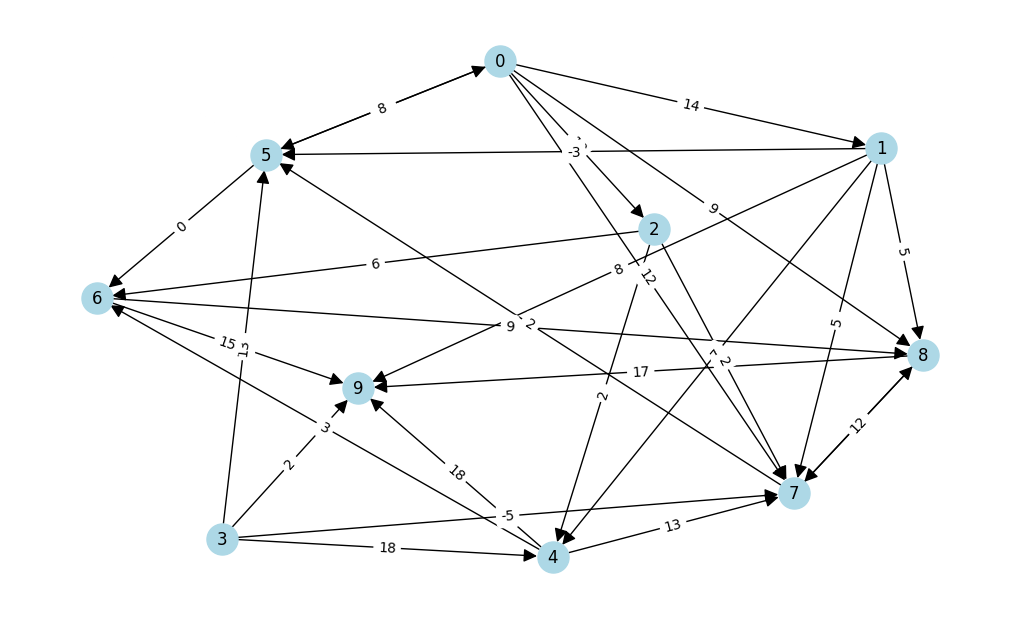

In [9]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

Implementation of Bellman-Ford algorithm that computes <b> the shortest path </b> <br>
from a single source vertext to all other vertices in a weighted digraph.

In [10]:
def bellman_ford_networkx(graph, source: int, show = True) -> dict:
    """
    The Bellman-Ford algorithm performed by
    NetworkX library.

    :param graph: Randomly generated graph
    :param start: int, Name of starting vertice (number in our case)
    :return: dict, Dictionary with keys as vertices and values as the 
    shortest distance to the each vertice.
    """
    try:
        _, dist = bellman_ford_predecessor_and_distance(graph, source)
        if show:
            for k, v in dist.items():
                print(f"Distance to {k}:", v)
    except:
        return "Negative cycle detected"
    return dist
print(bellman_ford_networkx(G, 0))

Distance to 0: 0
Distance to 1: 14
Distance to 2: 18
Distance to 5: 11
Distance to 7: 12
Distance to 8: 9
Distance to 4: 20
Distance to 9: 22
Distance to 6: 11
{0: 0, 1: 14, 2: 18, 5: 11, 7: 12, 8: 9, 4: 20, 9: 22, 6: 11}


### Implementation details
At the beggining function receives randomly generated graph, node to start algorithm performence from and the sign to show the distances in written form.

Then we extract edges, nodes, start node and initialize <b>distance_dict</b> - dictionary that contains information
about distances, with node as keys and distance as values.

### Starting the algorithm
- We initialize the distances to infinity, except for the start node - its distance is set to 0.
- Starting the main part - iterating for v-1 times, where v is a number of nodes of a graph.
We iterate through our directed graph and implement a checking if the sum of a distance to start
node in from node "u" in our 'table' of distances and the weight of a given edge is less than a distance to node v.
If so the distance from our node v is set to such sum (previously checked that if the node distance is set to infinity it is being reset to 0 for calculation)
- As a next step we perform another additional iteration as a checking if the graph contains any negative cycles. The checking is the exact copy of the previous iterations.
- As a result we print the results in written form and in dictionary as well.

In [11]:

def bellman_ford_algorithm(graph, start: int, show = True) -> dict:
    """
    The realization of Bellman-Ford algorithm
    that is used to find the shortest path in a directed
    weighted graph. 

    :param graph: Randomly generated graph
    :param start: int, Name of starting vertice (number in our case)
    :return: dict, Dictionary with keys as vertices and values as the 
    shortest distance to the each vertice.
    """
    edges = list(graph.edges(data = True))
    all_vertices = list(graph.nodes())
    sorted_graph = sorted(edges, key = lambda x: x)
    start_vertice = sorted_graph[start][0]
    distance_dict = {}

    for v in sorted(all_vertices):
        distance_dict[v] = float('inf')

    distance_dict[start_vertice] = 0
    for _ in range(len(all_vertices) - 1):
        for u, v, w in sorted_graph:
            if distance_dict[u] + w['weight'] < distance_dict[v]:
                distance_dict[u] = 0 if distance_dict[u] == float('inf') else distance_dict[u]
                distance_dict[v] = distance_dict[u] + w['weight']

    for u, v, w in sorted_graph:
        if distance_dict[u] + w['weight'] < distance_dict[v]:
            return "Negative cycle detected"

    
    if show:
        for v, distance in distance_dict.items():
            if distance != float('inf'):
                print(f'Distance to {v}: {distance}')
    return distance_dict

print(bellman_ford_algorithm(G, 0))

Distance to 0: 0
Distance to 1: 14
Distance to 2: 18
Distance to 4: 20
Distance to 5: 11
Distance to 6: 11
Distance to 7: 12
Distance to 8: 9
Distance to 9: 22
{0: 0, 1: 14, 2: 18, 3: inf, 4: 20, 5: 11, 6: 11, 7: 12, 8: 9, 9: 22}


---

## Time measuring for Kruskal's algorithm

In [12]:
import time
from tqdm import tqdm

In [13]:

def count_time(num_nodes: int, completeness: float, directed: bool, algorithm_name: str) -> float:
    """
    Counting runtime for each Kruskal's algorithm with given
    specifics of a graph, such as number of nodes, compeleteness and direction.

    :param num_nodes: list, List with number of nodes to check time for
    :param completeness: float, The completeness of a graph
    :param directed: bool, The direction of a graph
    :param algorithm_name: str, The "name" of an algorithm
    :return: float, Runtime of an algorithm
    """
    NUM_OF_ITERATIONS = 1000
    time_taken = 0
    for _ in tqdm(range(NUM_OF_ITERATIONS)):

        G = gnp_random_connected_graph(num_nodes, completeness, directed)
        start = time.time()
     
        if algorithm_name == "kruskal":
            tree.minimum_spanning_tree(G, algorithm="kruskal")
        else:
            kruskal_algorithm(G)

        end = time.time()
        time_taken += end - start

    return time_taken / NUM_OF_ITERATIONS


In [14]:
def testing_kruskal(num_nodes: list,\
     completeness: float, directed: bool) -> dict:
     """
     Processing of data, received after count_time function for
     of each implementation of Kruskal's algorithm for certain
     given number of nodes and completeness.

     :param num_nodes: list, List with number of nodes to check time for
     :param completeness: float, The completeness of a graph
     :param directed: bool, The direction of a graph
     :return: dict, The results of testing, key is a name of an algorithm,
     value is dictionary, which keys are the number of nodes in a graph 
     and values are runtimes
     """
     results = {}
     algorithms = ['our_kruskal', 'kruskal']

     for num in num_nodes:
          for algorithm in algorithms:
               run_time_res = count_time(num, completeness, directed, algorithm)
               if algorithm not in results:
                    results.setdefault(algorithm, {})
               results[algorithm][num] = run_time_res
     return results

100%|██████████| 1000/1000 [00:00<00:00, 12995.32it/s]


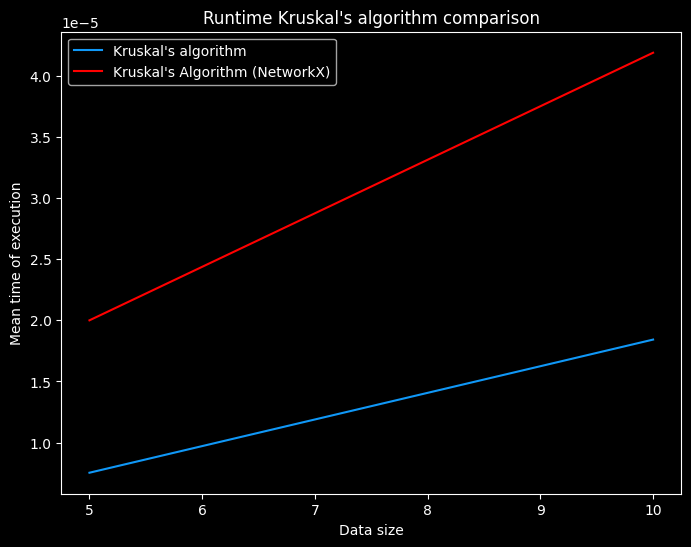

Visualization of runtime differences for 2 implementations of Kruskal's algorithm


In [15]:

def visualization_comparison_kruskal(results: dict) -> str:
    """
    The visualization of runtime differences
    of Kruskal's algorithms implemented by us 
    and NetworkX library using Matplotlib library.

    :param results: dict, The result of testing_kruskal function
    """
    nodes = np.array(list(results['our_kruskal'].keys()))
    our_kruskal_result = list(results['our_kruskal'].values())
    kruskal_result = list(results['kruskal'].values())

    plt.style.use('dark_background')
    plt.figure(figsize = (8, 6))
    plt.plot(nodes, our_kruskal_result, color = '#1098F7', label = "Kruskal's algorithm", linewidth = 1.5)
    plt.plot(nodes, kruskal_result, color = 'red', label = "Kruskal's Algorithm (NetworkX)", linewidth = 1.5)


    plt.title("Runtime Kruskal's algorithm comparison")
    plt.xlabel('Data size')
    plt.ylabel('Mean time of execution')
    plt.legend()
    plt.show()

    return "Visualization of runtime differences for 2 implementations of Kruskal's algorithm"

print(visualization_comparison_kruskal(testing_kruskal([5, 10], 0.4, False)))


- <b>500 iterations</b> <br>
For an example of 5, 10, 15, 20, 25, 50, 100, 200, 500 nodes, with completness 0.4 our algorithm works faster <br> 
on bigger examples and works almost the same on small ones (faster a little bit than implementation of NetworkX library).

Testing on the same example with completness 1 our algorithm continues to perform faster.

- <b>1000 iterations</b> <br>
The same tendency is kept on bigger amount and smaller amount of iterations, but same give characteristics. Our algorithm performs faster.

## Time measuring for Bellman-Ford algorithm

In [16]:

def count_time_bf(num_nodes: int, completeness: float, directed: bool, algorithm_name: str, start_node: int) -> float:
    """
    Counting runtime for each Bellman-Ford algorithm with given
    specifics of a graph, such as number of nodes, compeleteness and direction.

    :param num_nodes: list, List with number of nodes to check time for
    :param completeness: float, The completeness of a graph
    :param directed: bool, The direction of a graph
    :param algorithm_name: str, The "name" of an algorithm
    :param start_node: int, The node to start performing algorithm on
    :return: float, Runtime of an algorithm
    """
    NUM_OF_ITERATIONS = 100
    time_taken = 0
    for _ in tqdm(range(NUM_OF_ITERATIONS)):

        G = gnp_random_connected_graph(num_nodes, completeness, directed)
        start = time.time()
     
        if algorithm_name == "bellman-ford_x":
            bellman_ford_networkx(G, start_node, False)
        else:
            bellman_ford_algorithm(G, start_node, False)

        end = time.time()
        time_taken += end - start

    return time_taken / NUM_OF_ITERATIONS


In [17]:
def testing_bellman_ford(num_nodes: list,\
     completeness: float, directed: bool, start_node: int) -> dict:
     """
     Processing of data, received after count_time function for
     of each implementation of Bellman-Ford algorithm for certain
     given number of nodes and completeness.

     :param num_nodes: list, List with number of nodes to check time for
     :param completeness: float, The completeness of a graph
     :param directed: bool, The direction of a graph
     :param start_node: int, The node to start performing algorithm on
     :return: dict, The results of testing, key is a name of an algorithm,
     value is dictionary, which keys are the number of nodes in a graph 
     and values are runtimes
     """
     results = {}
     algorithms = ['bellman-ford', 'bellman-ford_x']

     for num in num_nodes:
          for algorithm in algorithms:
               run_time_res = count_time_bf(num, completeness, directed, algorithm, start_node)
               if algorithm not in results:
                    results.setdefault(algorithm, {})
               results[algorithm][num] = run_time_res
     return results

100%|██████████| 100/100 [00:00<00:00, 3287.43it/s]


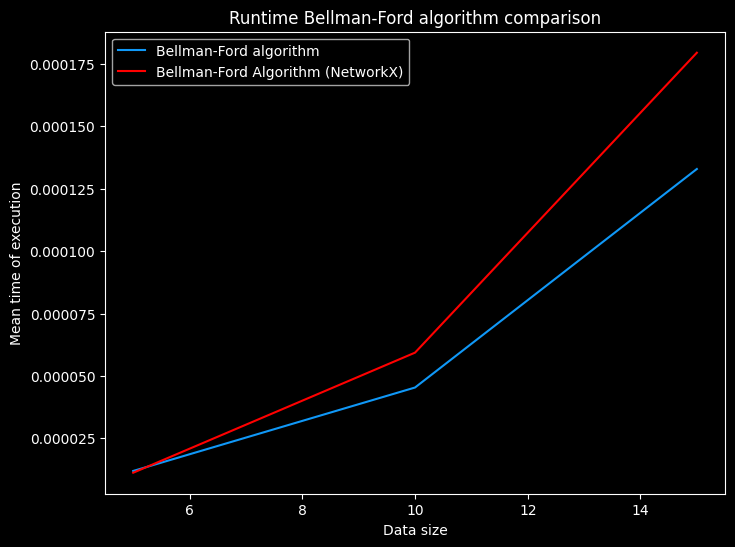

Visualization of runtime differences for 2 implementations of Bellman-Ford algorithm


In [18]:

def visualization_comparison_bellman_ford(results: dict) -> str:
    """
    The visualization of runtime differences
    of Bellman-ford algorithms implemented by us 
    and NetworkX library using Matplotlib library.

    :param results: dict, The result of testing_kruskal function
    """
    nodes = np.array(list(results['bellman-ford'].keys()))
    our_kruskal_result = list(results['bellman-ford'].values())
    kruskal_result = list(results['bellman-ford_x'].values())

    plt.style.use('dark_background')
    plt.figure(figsize = (8, 6))
    plt.plot(nodes, our_kruskal_result, color = '#1098F7', label = 'Bellman-Ford algorithm', linewidth = 1.5)
    plt.plot(nodes, kruskal_result, color = 'red', label = 'Bellman-Ford Algorithm (NetworkX)', linewidth = 1.5)


    plt.title('Runtime Bellman-Ford algorithm comparison')
    plt.xlabel('Data size')
    plt.ylabel('Mean time of execution')
    plt.legend()
    plt.show()

    return 'Visualization of runtime differences for 2 implementations of Bellman-Ford algorithm'

print(visualization_comparison_bellman_ford(testing_bellman_ford([5, 10, 15], 1, True, 0)))

This algorithm is harder to perform than Kruskal's algorithm that is why we test on 500 <= iterations <br>
For an example of 10, 15, 20, 25, 50, 100, 250 nodes, with completness 0.4 our algorithm works <br> 
a little bit slower on some points than implementation of NetworkX library. (tested for 200, 250, 500 iterations)

For completness of 1 our algorithm works faster of 200 iterations than NetworkX's algorithm.

## Task 2. Decision Tree Classifier 

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Loading data

In [19]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target


Text(0, 0.5, 'concave points ')

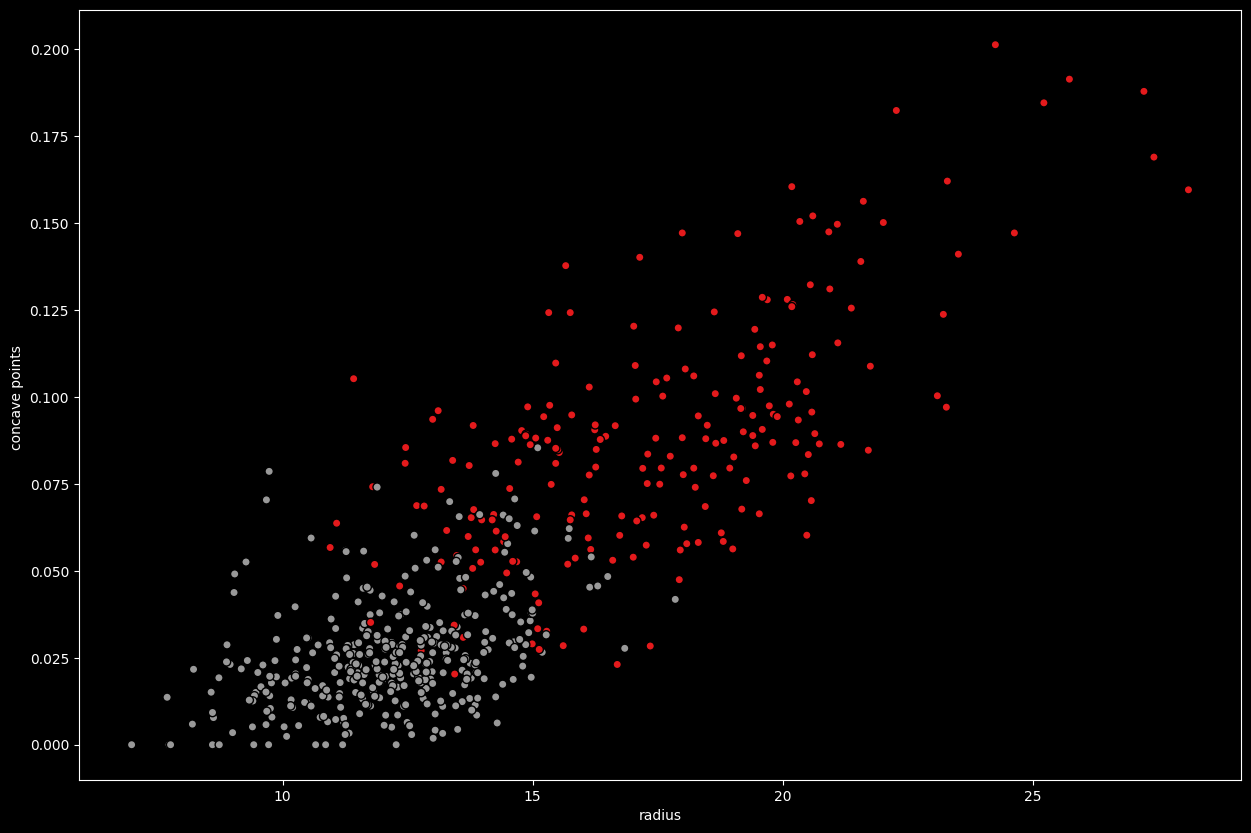

In [20]:

plt.figure(2, figsize=(15, 10))
plt.clf()

plt.scatter(X[:, 0]  , X[:, 7], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("radius")
plt.ylabel("concave points ")


_here we may see, how some features predict if a person has cancer or not._

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Our Decision Tree  Classifier

We spent couple of days and a lot of nerves to understand and develop this fascinating algorithm.

##### _Visualisation of the tree:_

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None
                    feature_names=cancer.feature_names,  
                    class_names=cancer.target_names,  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("cancer")
